# Instacart - Online Grocery Shopping
### Recommender Systems

The instacart Online Grocery Shopping Dataset will be used for this project. The data can be found at the below link:
<br>
<br>
“The Instacart Online Grocery Shopping Dataset 2017”, Accessed from https://www.instacart.com/datasets/grocery-shopping-2017

### Data

The Instacart data is as follow:

`orders` (3.4m rows, 206k users):
* `order_id`: order identifier
* `user_id`: customer identifier
* `eval_set`: which evaluation set this order belongs in (see `SET` described below)
* `order_number`: the order sequence number for this user (1 = first, n = nth)
* `order_dow`: the day of the week the order was placed on (0 = Sunday)
* `order_hour_of_day`: the hour of the day the order was placed on
* `days_since_prior`: days since the last order, capped at 30 (with NAs for `order_number` = 1)

`products` (50k rows):
* `product_id`: product identifier
* `product_name`: name of the product
* `aisle_id`: foreign key
* `department_id`: foreign key

`aisles` (134 rows):
* `aisle_id`: aisle identifier
* `aisle`: the name of the aisle

`deptartments` (21 rows):
* `department_id`: department identifier
* `department`: the name of the department

`order_products_prior` (30m+ rows):
This set includes orders prior to the users' most recent order
* `order_id`: foreign key
* `product_id`: foreign key
* `add_to_cart_order`: order in which each product was added to cart
* `reordered`: 1 if this product has been ordered by this user in the past, 0 otherwise

`order_products_train` (30m+ rows):
This set will be used to test our recommender model
* `order_id`: foreign key
* `product_id`: foreign key
* `add_to_cart_order`: order in which each product was added to cart
* `reordered`: 1 if this product has been ordered by this user in the past, 0 otherwise


In [1]:
# import packages needed
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# set max printout options for pandas:
pd.options.display.max_columns = 50
pd.options.display.max_colwidth = 300

from matplotlib.ticker import FuncFormatter

In [2]:
# Load in the data from the different files
orders = pd.read_csv('Data/instacart_2017_05_01/orders.csv', header =0)
products = pd.read_csv('Data/instacart_2017_05_01/products.csv', header = 0) 
aisles = pd.read_csv('Data/instacart_2017_05_01/aisles.csv', header = 0) 
departments = pd.read_csv('Data/instacart_2017_05_01/departments.csv', header = 0)
order_products_prior = pd.read_csv('Data/instacart_2017_05_01/order_products__prior.csv', header = 0) 
order_products_train = pd.read_csv('Data/instacart_2017_05_01/order_products__train.csv', header = 0) 

In [3]:
orders['order_id'].unique().shape

(3421083,)

In [4]:
products['product_id'].unique().shape

(49688,)

In [5]:
departments['department_id'].unique().shape

(21,)

In [6]:
orders['user_id'].unique().shape

(206209,)

In [7]:
orders.head(3)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0


In [8]:
products.head(3)

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7


In [9]:
departments.head(3)

,department_id,department
0,1,frozen
1,2,other
2,3,bakery


In [10]:
order_products_prior.head(3)

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0


### Data Analysis

### Top Ordered Products

#### Top Ordered Products overall - What are the best selling items?

Below, we can see the most ordered products. We can also see that most of these products are from the produce section. 

In [11]:
s = order_products_prior['product_id'].value_counts().sort_values(ascending = False).head(10)
((pd.DataFrame({'product_id':s.index,'count':s.values})).merge(products, how = 'inner', left_on = 'product_id',
                                                             right_on = 'product_id')).merge(departments,
                                                            how = 'inner', left_on = 'department_id', 
                                                            right_on = 'department_id')[
    ['count','product_name','department']
]

,count,product_name,department
0,472565,Banana,produce
1,379450,Bag of Organic Bananas,produce
2,264683,Organic Strawberries,produce
3,241921,Organic Baby Spinach,produce
4,213584,Organic Hass Avocado,produce
5,176815,Organic Avocado,produce
6,152657,Large Lemon,produce
7,142951,Strawberries,produce
8,140627,Limes,produce
9,137905,Organic Whole Milk,dairy eggs


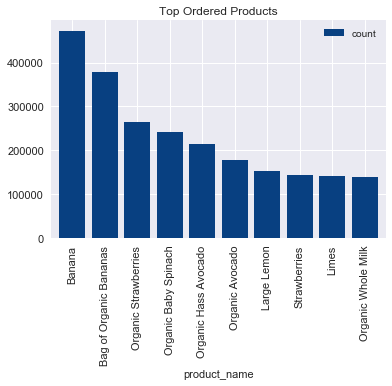

In [12]:
s = order_products_prior['product_id'].value_counts().sort_values(ascending = False).head(10)
((pd.DataFrame({'product_id':s.index,'count':s.values})).merge(products, how = 'inner', left_on = 'product_id',
                                                             right_on = 'product_id')).merge(departments,
                                                            how = 'inner', left_on = 'department_id', 
                                                            right_on = 'department_id')[['product_name','count']
].plot(kind = 'bar', x = 'product_name', y = 'count', colormap = 'GnBu_r', title = 'Top Ordered Products',
      fontsize = 11, width = .8);

#### Top Ordered Products per Department in the Top 3 Selling Departments - What are the best selling items per department?

In [13]:
# Joining Orders, Products and Departments into a single Dataframe
s = order_products_prior['product_id'].value_counts().sort_values(ascending = False)
df = ((pd.DataFrame({'product_id':s.index,'count':s.values})).merge(products, how = 'inner', left_on = 'product_id',
                                                             right_on = 'product_id')).merge(departments,
                                                            how = 'inner', left_on = 'department_id', 
                                                            right_on = 'department_id')[
    ['count','product_name','department']]

In [14]:
# Top 3 Departments
df['department'].unique()[:3]

array(['produce', 'dairy eggs', 'beverages'], dtype=object)

In [15]:
df['department'].unique()

array(['produce', 'dairy eggs', 'beverages', 'deli', 'bakery', 'frozen',
       'meat seafood', 'pantry', 'canned goods', 'household', 'breakfast',
       'snacks', 'dry goods pasta', 'international', 'bulk', 'babies',
       'missing', 'alcohol', 'personal care', 'other', 'pets'], dtype=object)

In [16]:
# Function to get Top Products for a specific Department
def top_department(department):
    return df[df['department']== department].head(3)

Below, we can see the most ordered products per the top 3 departments. 

In [17]:
df2 = pd.DataFrame()
for department in df['department'].unique()[:3]:
    data = top_department(department)
    df2 = pd.concat([df2,data],axis = 0)
df2

,count,product_name,department
0,472565,Banana,produce
1,379450,Bag of Organic Bananas,produce
2,264683,Organic Strawberries,produce
1684,137905,Organic Whole Milk,dairy eggs
1685,76360,Organic Half & Half,dairy eggs
1686,69217,Half & Half,dairy eggs
5132,75886,Sparkling Water Grapefruit,beverages
5133,56087,Spring Water,beverages
5134,46546,Lime Sparkling Water,beverages


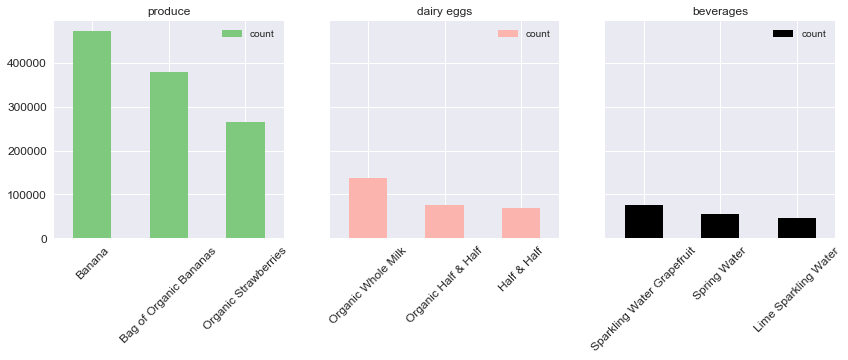

In [18]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
plt.xlabel = ''

i = 1
for department in df['department'].unique()[:3]:
    if i == 1:
        ax = ax1
        colormap = 'Accent'
    if i == 2:
        ax = ax2
        colormap = 'Pastel1'
    if i == 3:
        ax = ax3
        colormap = 'copper'
    title = department
    df2[df2['department']==department].plot(kind = 'bar', x = 'product_name', y = 'count', ax = ax, figsize = (14,4),
                                            fontsize = 12, title = title, colormap = colormap, rot = 45)
    i = i + 1
    
ax1.set_xlabel('')
ax2.set_xlabel('')
ax3.set_xlabel('');
# Try to fix the horizontal alignment to right to move the xticks to the left

In [19]:
# Top Selling items in Personal Care
top_department('personal care')

,count,product_name,department
41594,5941,Lavender Hand Soap,personal care
41595,4951,Lemon Verbena Hand Soap,personal care
41596,4228,Premium Epsom Salt,personal care


In [20]:
# Top Selling items in Dairy Eggs
top_department('dairy eggs')

,count,product_name,department
1684,137905,Organic Whole Milk,dairy eggs
1685,76360,Organic Half & Half,dairy eggs
1686,69217,Half & Half,dairy eggs


In [21]:
# Top Selling items in Alcohol
top_department('alcohol')

,count,product_name,department
40540,8246,Sauvignon Blanc,alcohol
40541,6153,Chardonnay,alcohol
40542,6115,Cabernet Sauvignon,alcohol


### Order Frequency

#### Frequency of orders - How long do customers usually wait to place another order?

As seen in graph below, there is a spike at 7 days and at 30 days. So most re-orders happen either weekly or monthly.

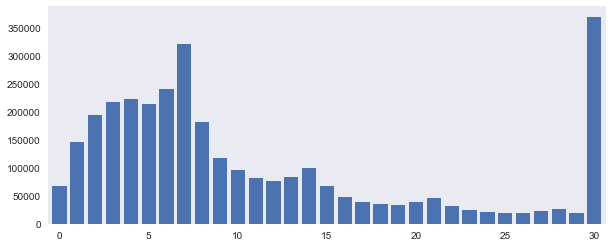

In [22]:
fig, ax = plt.subplots(1,1);
orders['days_since_prior_order'].value_counts().sort_index().plot(kind = 'bar', width = 0.8, figsize = (10,4), 
                                                                  grid = False, 
                                                                 use_index = False, rot = 0);

for label in ax.get_xticklabels()[1:5]:
    label.set_visible(False)
for label in ax.get_xticklabels()[6:10]:
    label.set_visible(False)
for label in ax.get_xticklabels()[11:15]:
    label.set_visible(False)
for label in ax.get_xticklabels()[16:20]:
    label.set_visible(False)
for label in ax.get_xticklabels()[21:25]:
    label.set_visible(False)
for label in ax.get_xticklabels()[26:30]:
    label.set_visible(False)

### Order Size

#### How many items are usually on an order?

The graph below shows that most orders will usually have around 5 to 10 items.

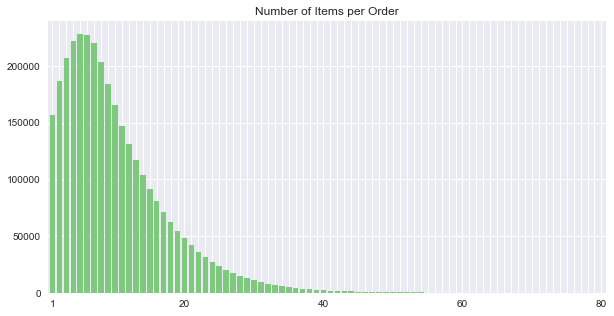

In [23]:
s2 = order_products_prior.groupby('order_id')['add_to_cart_order'].max().value_counts().sort_index()
fig, ax2 = plt.subplots(1,1)
(s2[0:80]).plot(kind = 'bar', x = 'lines',y='count', width = 0.8, figsize = (10,5), rot = 0, 
                title = 'Number of Items per Order', fontsize = 10, colormap = 'Accent');
for label in ax2.get_xticklabels()[1:19]:
    label.set_visible(False)
for label in ax2.get_xticklabels()[20:39]:
    label.set_visible(False)
for label in ax2.get_xticklabels()[40:59]:
    label.set_visible(False)
for label in ax2.get_xticklabels()[60:79]:
    label.set_visible(False)

### Product Reorder Rates

What percent of order lines are being reordered by customers? If products are being reordered, then it might be useful to predict which products customers are likely to buy on their next purchase. This will allow for better recommendations to improve the customer experience.

How many orders had reordered items?<br>
How many order lines/items were reordered?<br>
<br>
About 93% of orders had a least one (1) reoredered item, and about 63% of order line items were reordered. <br>
A very large portion of non-first time orders were reorders. In this case it might be worth it to add some recommendation algorithms for customers likely to reorder.

In [24]:
# A = Count number of orders where reordered items >= 1 / Total orders
# Exclude first time orders

df4 = pd.DataFrame(order_products_prior.groupby('order_id')['reordered'].sum())
(((df4[(df4['reordered']>= 1)&
       (df4.index.isin(orders[orders['order_number']>1]['order_id'].values)
                              )]).shape[0])/float(
    ((order_products_prior[order_products_prior['order_id'].isin(orders[orders['order_number']>1]['order_id'
                                                    ].values)]['order_id'].unique()).shape[0])))*100

93.94070127448553

In [25]:
# Count number of lines where reordered = 1
# Exclude first time orders
(((order_products_prior[(order_products_prior['reordered']>= 1)&
       (order_products_prior['order_id'].isin(orders[orders['order_number']>1]['order_id'].values)
                              )]).shape[0])/float(
    ((order_products_prior[order_products_prior['order_id'].isin(orders[orders['order_number']>1]['order_id'].values)]
                                                   ).shape[0])))*100

63.006557986529444

Let's also look at the customer level. What percent of customers have reordered at least once?<br>
What percent has reordered at least twice?<br>
<br>
It looks like about 98% of customers have reordered at least once, and 96% have reordered at least twice.

In [26]:
df5 = order_products_prior.merge(orders[['order_id','user_id']], 
                                      how = 'inner', left_on = 'order_id', right_on = 'order_id')
df5 = pd.DataFrame(df5.groupby('user_id')['reordered'].sum())
(((df5[(df5['reordered']>= 1)&
       (df5.index.isin(orders[orders['order_number']>1]['user_id'].values)
                              )]).shape[0])/float(
    (((orders[orders['order_number']>1]['user_id'].unique()).shape[0]))))*100

98.52334282208827

In [27]:
df5 = order_products_prior.merge(orders[['order_id','user_id']], 
                                      how = 'inner', left_on = 'order_id', right_on = 'order_id')
df5 = pd.DataFrame(df5.groupby('user_id')['reordered'].sum())
(((df5[(df5['reordered']>= 2)&
       (df5.index.isin(orders[orders['order_number']>1]['user_id'].values)
                              )]).shape[0])/float((orders[orders['order_number']>1]['user_id'].unique(
                                )).shape[0]))*100

96.1713601249218

What is the reorder percent per department?<br>
The top 3 departments with the highest percentage of reordered products are Dairy eggs, Beverages and Produce, with Personal Care having the lowest percentage.

In [28]:
# Join orders, products and departments to get department with reordered column
df6 = order_products_prior.merge(orders[['order_id','user_id']], 
                                      how = 'inner', left_on = 'order_id', right_on = 'order_id').merge(
                                        products[['product_id','department_id']], how = 'inner',
                                        left_on = 'product_id', right_on = 'product_id').merge(
                                        departments, left_on ='department_id', right_on = 'department_id')
# Filter out the first time orders
df6 = df6[df6['order_id'].isin(orders[orders['order_number']>1]['order_id'].values)]

# Group by department then count the number of reorders divided by the number of order lines in each department
# Count where reoredered = 1 and divide by count of all order lines in department
df7 = pd.DataFrame()
df7['sum'] = df6.groupby('department')['reordered'].sum()
df7['count'] = df6.groupby('department')['reordered'].count()
df7['dep_reorders'] = df7['sum']/df7['count']
df7 = df7.sort_values('dep_reorders', ascending = False)


In [29]:
df7['dep_reorders'].head(10)

department
dairy eggs      0.713881
beverages       0.696882
produce         0.692611
bakery          0.671229
deli            0.651138
pets            0.644998
alcohol         0.621320
snacks          0.612557
babies          0.611412
meat seafood    0.608319
Name: dep_reorders, dtype: float64

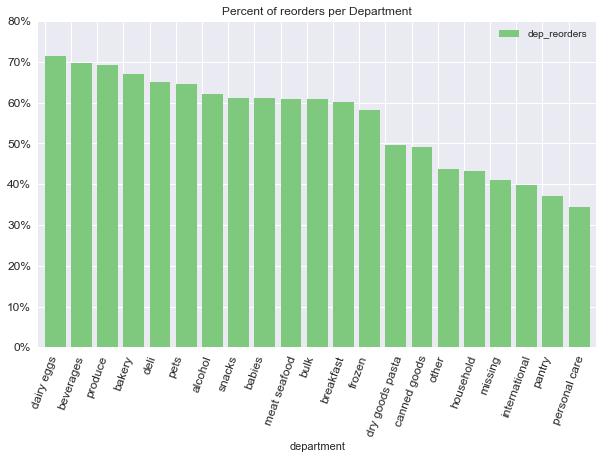

In [30]:
df8 = df7.plot(kind = 'bar', x = df7.index, y = 'dep_reorders', 
                        title = 'Percent of reorders per Department', 
                         colormap = 'Accent', figsize = (10,6), ylim = (0,.8), fontsize = 12, rot = 70, width = 0.8,
                          position = 0.0)
df8.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)));

Which products are reordered the most?<br>
Looking only at items that were ordered 200 times or more, below are the top reordered items. Also below are the least reordered items which are mostly spices which is not surprising since spices tend to last longer.

In [31]:
# Use the joined dataframe df6 from above
df10 = pd.DataFrame()
df10['reorder_sum'] = df6.groupby('product_id')['reordered'].sum()
df10 = df10[df10['reorder_sum']>200]

# Filter products that were reordered less than 40 times
df6 = df6[(df6['order_id'].isin(orders[orders['order_number']>1]['order_id'].values))&(
            df6['product_id'].isin(df10.index.values))]

# Group by product then count the number of reorders divided by the number of order lines for each product
# Count where reoredered = 1 and divide by count of all order lines in department
df9 = pd.DataFrame()
df9['sum'] = df6.groupby('product_id')['reordered'].sum()
df9['count'] = df6.groupby('product_id')['reordered'].count()
df9['product_reorders'] = df9['sum']/df9['count']
df9 = df9.sort_values('product_reorders', ascending = False)
df11 = df9.merge(products, left_on = df9.index.values, right_on = 'product_id')[['product_name','product_reorders']]
df11.head()

,product_name,product_reorders
0,Lo-Carb Energy Drink,0.902935
1,Organic Reduced Fat Milk,0.899997
2,Banana,0.899732
3,Organic Low Fat Milk,0.899336
4,Ultra-Purified Water,0.898031


In [32]:
df11.tail()

,product_name,product_reorders
9142,Chili Powder,0.122098
9143,Onion Powder,0.105619
9144,Baking Powder,0.096645
9145,Bay Leaves,0.084116
9146,Paprika,0.083302


Calculating the probability customers will re-order specific items.

In [33]:
df12 = order_products_prior.merge(orders, left_on = 'order_id', right_on = 'order_id')

In [34]:
# Use the joined dataframe df6 from above
df13 = pd.DataFrame()
# Find the first order of each item for a user
df13['first_order'] = df12.groupby(['user_id','product_id'])['order_number'].min()
# Find the last order of the user
df13 = df13.merge(pd.DataFrame(df12.groupby(['user_id'])['order_number'].max()), 
           left_index = True, right_index = True, how = 'left')
# Find the number of orders made by user for which the user could have reordered the item
df13['num_orders'] = df13['order_number']- df13['first_order']
# Find the number of reorders for the item
df13['reorder_sum'] = df12.groupby(['user_id','product_id'])['reordered'].sum()
# Remove products that were ordered on the last order (since we will not know if that product was reordered)
df13 = df13[df13['first_order']!= df13['order_number']]
# Calculate the percentage of reorder
df13['reorder_percent'] = df13['reorder_sum']/df13['num_orders']


In [35]:
# Group the above dataframe by the product_id and calculate the average percentage of reorders# 
df14 = (pd.DataFrame(df13.groupby(level = 1)['reorder_percent'].mean()))
# Group the above dataframe by the product_id and calculate the total number of reorders
df14['reorder_sum'] = df13.groupby(level = 1)['reorder_sum'].sum()
# Filter out products that was ordered less than 100 times
df14 = df14[df14['reorder_sum']>100]
# Merge to get the product names
df15 = df14.merge(products, left_on = df14.index.values, right_on = 'product_id')
df15.sort_values('reorder_percent', ascending = False)[['product_name','reorder_percent']].head()


,product_name,reorder_percent
4672,Lo-Carb Energy Drink,0.429457
10558,Bananas,0.429274
5600,Organic Low Fat Milk,0.414616
6617,Banana,0.392647
2302,Thyme Hummos,0.383577


In [36]:
df15.sort_values('reorder_percent', ascending = False)[['product_name','reorder_percent']].tail()

,product_name,reorder_percent
2990,Seasoning Paprika,0.006586
643,Cayenne Pepper,0.006462
4714,Premium Fish Sauce,0.006266
2194,Ground Ginger,0.005834
1482,Sesame Seed,0.005463


### Distribution of Departments by Product Sales Volume

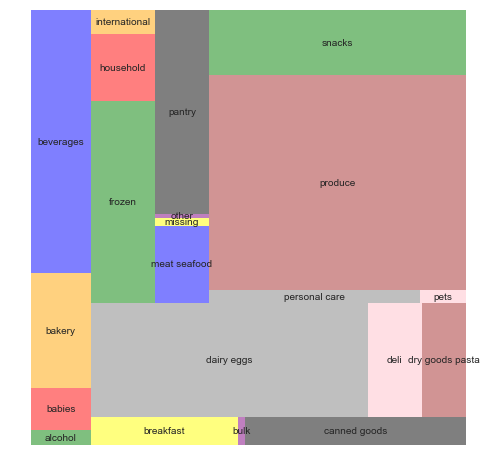

In [37]:
import matplotlib.pyplot as plt
import squarify

fig = plt.figure(figsize=(60,8))
ax = fig.add_subplot(111, aspect="equal")


s20 = df.groupby('department')['count'].sum()
df20 = pd.DataFrame({'department':s20.index, 'count':s20.values})
ax = squarify.plot(sizes=df20['count'], label=df20['department'], alpha=.5, color = ['green',
                                                'red','orange','blue','yellow','purple','black','gray','pink','brown'])
plt.axis('off')
plt.show()

### Products ordered together

What products are usually ordered together? This can be used to recommend products to customers when buying a specific item that is likely to be bought along with another item.

In [38]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from mlxtend.preprocessing import OnehotTransactions

Let's find the most frequent ordered sets of items from a sample of orders. The most ordered sets of items contain Bananas which is not suprising as Bananas are the most ordered product.

In [39]:
# Joining orders and products
df30 = order_products_prior.merge(products, how = 'inner', left_on = 'product_id', right_on = 'product_id')

In [41]:
# Group by order id and get all products on an order into a single list
s30 = df30.sort_values('product_name').groupby('order_id')['product_name'].agg(lambda x: list(x))

In [42]:
# Initiate OnehotTransactions to fit and transform the dataset for affinity
oht = OnehotTransactions()

In [47]:
# Fit and Transform a sample of 50,000 orders
sample30 = s30.sample(n = 50000)
oht_ary = oht.fit(sample30.values).transform(sample30.values)

In [48]:
# Transfor the results into a dataframe
df32 = pd.DataFrame(oht_ary, columns=oht.columns_)

In [52]:
# Get the frequent ordered sets of items
frequent_itemsets = apriori(df32, min_support=0.01, use_colnames=True)
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
frequent_itemsets[frequent_itemsets['length']> 1].sort_values('support', ascending = False)

,support,itemsets,length
105,0.01894,"[Bag of Organic Bananas, Organic Strawberries]",2
103,0.01864,"[Bag of Organic Bananas, Organic Hass Avocado]",2
110,0.01730,"[Banana, Organic Strawberries]",2
107,0.01574,"[Banana, Organic Avocado]",2
108,0.01548,"[Banana, Organic Baby Spinach]",2
102,0.01524,"[Bag of Organic Bananas, Organic Baby Spinach]",2
112,0.01260,"[Banana, Strawberries]",2
115,0.01250,"[Organic Hass Avocado, Organic Strawberries]",2
104,0.01230,"[Bag of Organic Bananas, Organic Raspberries]",2
106,0.01222,"[Banana, Large Lemon]",2


Looking at orders containing bananas. 

In [53]:
orders_set = df30[df30['product_name'].isin(['Banana'])]['order_id'].unique()

In [54]:
df33 = df30[df30['order_id'].isin(orders_set)]

In [55]:
s33 = df33.sort_values('product_name').groupby('order_id')['product_name'].agg(lambda x: list(x))

In [56]:
sample33 = s33.sample(n = 20000)
oht_ary2 = oht.fit(sample33.values).transform(sample33.values)

In [57]:
df34 = pd.DataFrame(oht_ary2, columns=oht.columns_)

In [58]:
frequent_itemsets2 = apriori(df34, min_support=0.1, use_colnames=True)
frequent_itemsets2['length'] = frequent_itemsets2['itemsets'].apply(lambda x: len(x))
frequent_itemsets2[frequent_itemsets2['length']> 1].sort_values('support', ascending = False)

,support,itemsets,length
6,0.11820,"[Banana, Organic Strawberries]",2
4,0.11305,"[Banana, Organic Avocado]",2
5,0.10680,"[Banana, Organic Baby Spinach]",2


Looking at orders containing 'Eggs'. The majority of customers who buy Eggs will also buy Onions, and Tomatoes.

In [59]:
orders_set2 = df30[df30['product_name'].isin(['Eggs'])]['order_id'].unique()

In [60]:
df35 = df30[df30['order_id'].isin(orders_set2)]

In [61]:
s35 = df35.sort_values('product_name').groupby('order_id')['product_name'].agg(lambda x: list(x))

In [62]:
#sample35 = s35.sample(n = 20000)
oht_ary3 = oht.fit(s35.values).transform(s35.values)

In [63]:
df36 = pd.DataFrame(oht_ary3, columns=oht.columns_)

In [64]:
frequent_itemsets3 = apriori(df36, min_support=0.09, use_colnames=True)
frequent_itemsets3['length'] = frequent_itemsets3['itemsets'].apply(lambda x: len(x))
frequent_itemsets3[frequent_itemsets3['length']> 1].sort_values('support', ascending = False)

,support,itemsets,length
5,0.359882,"[Banana, Eggs]",2
7,0.117994,"[Eggs, Roma Tomato]",2
6,0.109145,"[Eggs, Large Lemon]",2
8,0.100295,"[Eggs, White Onion]",2
